In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from category_encoders import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from warnings import filterwarnings
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
import os
import matplotlib.pyplot as plt
import seaborn as sns
filterwarnings('ignore')


In [2]:
# Load data
do_sample = False
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

if do_sample:
    train = train.sample(frac=0.1, random_state=1)
    

print("train data shape", train.shape)
print("test data shape", test.shape)


train data shape (400665, 202)
test data shape (399335, 201)


In [3]:
train["A_avg"] = (train["A_1"]+train["A_2"]) / 2
for i in range(165):
    train["XD_"+str(i+1)+str(i+2)] = (train["D_"+str(i+1)]+train["D_"+str(i+2)])/2 
    
train.fillna(value=-1)
test.fillna(value=-1)

target_column = "target"
id_column = "id"
categorical_cols = [c for c in test.columns if test[c].dtype in [np.object]]
numerical_cols = [c for c in test.columns if test[c].dtype in [np.float, np.int] and c not in [target_column, id_column]]
print("Number of features", len(categorical_cols)+len(numerical_cols))


Number of features 200


In [4]:
train_input = train.drop(['id','target','B_15'],axis = 1)
train_labels = train['target']
app_train = pd.get_dummies(train_input)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(app_train)
train_imputed = imp_mean.transform(app_train)
scaler = StandardScaler()
scaler.fit(train_imputed)
train_imputed = scaler.transform(train_imputed)
features = list(app_train.columns)
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(train_imputed,train_labels)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance':feature_importance_values})

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.1s finished


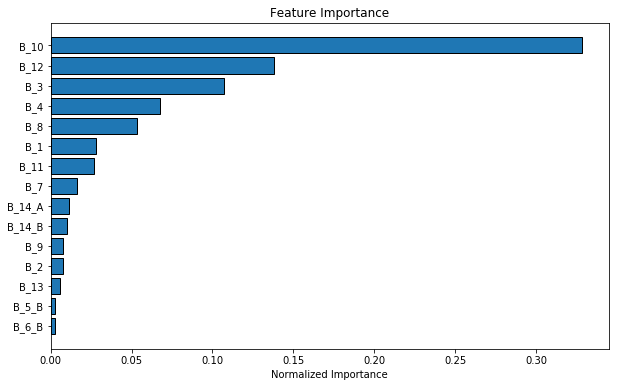

In [5]:
def plot_feature_importances(df):
    #Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    #Normalise the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    #Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10,6))
    ax = plt.subplot()
    
    #Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    #Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    #Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importance')
    plt.show()
    
    return df
feature_importances_sorted = plot_feature_importances(feature_importances)

In [14]:
categorical_cols = [c for c in test.columns if test[c].dtype in [np.object]]
numerical_cols = [c for c in test.columns if test[c].dtype in [np.float, np.int] and c not in [target_column, id_column]]
preprocess = make_column_transformer(
    (numerical_cols, make_pipeline(SimpleImputer(), StandardScaler())),
    (categorical_cols, OneHotEncoder()))

In [6]:
train=train[['target','B_15','B_10','B_3','B_12','B_8','B_7','B_4','D_121','D_26','D_17','B_11','D_56','D_138','D_1','D_40','D_166',
            'C_10','D_102','D_132','D_99','C_14','C_3','C_2','D_13','D_34','D_66','D_2','D_142','D_143','D_21','D_156','D_158','D_37','B_9',
            'D_14','C_12','D_28','D_6','D_29','D_54','D_117','C_5','D_86','D_107','D_30']]
test=test[['B_15','B_10','B_3','B_12','B_8','B_7','B_4','D_121','D_26','D_17','B_11','D_56','D_138','D_1','D_40','D_166',
            'C_10','D_102','D_132','D_99','C_14','C_3','C_2','D_13','D_34','D_66','D_2','D_142','D_143','D_21','D_156','D_158','D_37','B_9',
            'D_14','C_12','D_28','D_6','D_29','D_54','D_117','C_5','D_86','D_107','D_30']]

In [9]:
column_transformer = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [15]:
classifier_lgbm = make_pipeline(preprocess,LGBMClassifier(n_jobs=-1,eta=0.01,max_depth=4))

In [12]:
classifier_xgb = make_pipeline(
    column_transformer,
    XGBClassifier(n_jobs = -1)   
)

In [13]:
classifier_rf = make_pipeline(column_transformer,RandomForestClassifier(random_state=42))
classifier_svm = make_pipeline(svm.SVC(column_transformer,random_state=42))

#pipe_lr_pca = make_pipeline(column_transformer, LogisticRegression(random_state=42))
#pipe_rf_pca = make_pipeline(column_transformer,RandomForestClassifier(random_state=42))
#pipe_svm_pca = make_pipeline( svm.SVC(column_transformer,random_state=42))

voting_classifier = VotingClassifier(estimators=[
    ('lgbm', classifier_lgbm), 
    ('xgb', classifier_xgb)], 
    #('rf', classifier_rf),
    #('svm', classifier_svm)],
                 voting='soft', n_jobs=-1)

In [16]:
oof_pred_lgbm = cross_val_predict(classifier_lgbm, 
                             train, 
                             train[target_column], 
                             cv=5,
                             method="predict_proba", verbose=20)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.2s finished


In [17]:
print("Cross validation AUC {:.4f}".format(roc_auc_score(train[target_column], oof_pred_lgbm[:,1])))
classifier_lgbm.fit(train, train[target_column])
test_preds_lgbm = classifier_lgbm.predict_proba(test)[:,1]

Cross validation AUC 0.6422


In [30]:
oof_pred_xgb = cross_val_predict(classifier_xgb, 
                             train, 
                             train[target_column], 
                             cv=5,
                             method="predict_proba", verbose=20)
print("Cross validation AUC {:.4f}".format(roc_auc_score(train[target_column], oof_pred_xgb[:,1])))
classifier_xgb.fit(train, train[target_column])
test_preds = classifier_xgb.predict_proba(test)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.1min remaining:    0.0s


KeyboardInterrupt: 

In [18]:
sub = pd.read_csv("data/sample_submission.csv")
sub.head()
sub[target_column] = test_preds_lgbm
sub.to_csv("results/submit_results.csv", index=False)
print('done')

done


In [19]:
%%bash
kaggle competitions submit -c kaggledays-sf-hackathon -f results/submit_results.csv -m "crawl"

Successfully submitted to KaggleDays SF Hackathon

100%|██████████| 10.7M/10.7M [00:01<00:00, 5.89MB/s]
